# Advanced Example: Dynamic Hedging with Incomplete Information
This advanced example relaxes one of the key assumptions we made in the worked example, namely that we have perfect information. In particular, we still assume no market friction, i.e., buy/sell orders for the `TSLA` shares that make up the hedge are instantly filled at the specified price. However, we now consider the case in which trade decisions are made with data that _is not correct_, i.e., the model cannot access perfect information.
* There are several ways we could have implemented this example. However, in this case, we simply select different sample paths from the same random process models for share price and volatility we constructed previously. We designate one set of data as `true` while a second set as `model.` The `model` data is used to make the hedge decisions.

### Learning objective
* __Task 1__: Load simulation data from the worked example. Before simulating the hedge on the `TSLA` put option, we load the simulation state file generated in the worked example and use the data to set constants and other items used throughout this advanced example.
* __Task 2__: Construct a dynamically hedged position on a `TSLA` put. In this task, we'll dynamically compute the number of shares in the hedged position that are required to exactly maintain the liquidation value of the position, where the change in premium is calculated using the binomial model, assuming _incorrect_ information
    * `TODO`: Build a `TSLA` put contract model
    * `TODO`: Simulate a Dynamic Equity Hedge assuming incorrect information and no market friction, where the binomial model is used to compute the put option premium.
    * `TODO`: Build profit, loss, and cost table for the incorrectly hedged `TSLA` position

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Installed MKL_jll ───────── v2024.2.0+0
   Installed IntelOpenMP_jll ─ v2024.2.0+0
   Installed SentinelArrays ── v1.4.5
  N

## Task 1: Load simulation data from the worked example
Before setting up the hedge on the `TSLA` put option, let's load the simulation state file we generated in the worked example. To load the state file, we will use [the `load(...)` method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl), and we will provide the path to the save file as an argument in the `path_to_save_file::String` variable:

In [5]:
path_to_save_file = joinpath(_PATH_TO_DATA, "CHEME-134-M4-WorkedExample-State.jld2");

Then, use [`load(...)` method](https://github.com/JuliaIO/JLD2.jl) to load the file and return a dictionary with the keys specified in the worked example; we save this dictionary in the `my_simulation_dict::Dict{String, Any}` variable:

In [7]:
my_simulation_dict = load(path_to_save_file)

Dict{String, Any} with 14 entries:
  "risk_free_rate"                   => 0.0431
  "T"                                => 0.165753
  "number_of_samples"                => 1000
  "h"                                => 366
  "DTE"                              => 60.5
  "samples_share_price"              => [261.49 261.49 … 261.49 261.49; 261.308…
  "sample_synthetic_index"           => 568
  "samples_IV"                       => [0.605621 0.605621 … 0.605621 0.605621;…
  "perfect_hedge_simulation_example" => Dict{Int64, NamedTuple}(5=>(shares = 43…
  "Δt"                               => 1.0175e-5
  "example_put_contract"             => Dict{String, Any}("day"=>Dict{String, A…
  "number_of_trading_periods"        => 120
  "put_option_model"                 => MyAmericanPutContractModel(260.0, 1, 0.…
  "β"                                => 2.32

### Constants
Now that we have loaded the save file, we specify values for the constants used in the example by passing the respective keys to the variable `my_simulation_dict::Dict{String, Any}.`
- The variable `DTE::Float64` represents the days to the expiration of the options contracts (measured in days), `Δt::Float64` represents the time step used in the simulations. In this case, we are using 1-minute aggregate data (measured in years). The variable `number_of_trading_periods::Int64` represents the number of trading periods we explore, i.e., the number of minutes that we want to simulate, and `T::Float64` denotes the length of the options contracts (measured in years).
- Next, we retrieve information about `TSLA` and the parameters for the binomial lattice used in the simulation. The variable `β::Float64` represents the beta value for `TSLA`, `h::Int64` represents the number of levels of the pricing tree, the variable `risk_free_rate::Float64` represents the risk-free rate (in this case assumed to be the yield on a 10-year US Treasury Note), the variable `number_of_samples::Int64` specifies the number of samples (alternative futures) we will generate in the simulation, and finally, `sample_synthetic_index::Int64` is a randomly chosen index which specifies which sample we'll use in the simulation.

In [9]:
DTE = my_simulation_dict["DTE"]; # data from mid-day, add a little something something so we recover the midpoint premium (ish) (all parameters fixed)
Δt = my_simulation_dict["Δt"]; # 1-min trading periods
number_of_trading_periods = my_simulation_dict["number_of_trading_periods"]; # How many trading periods will we simulate?
T = my_simulation_dict["T"]; # Duration of trading periods in option years
β = my_simulation_dict["β"]; # TSLA 5y monthly beta value 06-25-24
h = my_simulation_dict["h"]; # 6-points per trading period
risk_free_rate = my_simulation_dict["risk_free_rate"]; # yield 10-year treasury note on 13-Jun-2024
number_of_samples = my_simulation_dict["number_of_samples"]; # number of samples to generate
sample_synthetic_index_true = my_simulation_dict["sample_synthetic_index"]; # generate random synthetic index to explore (must be <= number_of_samples)

568

Finally, let's randomly generate an index associated with the model, i.e., the column of data in the price and volatility array that the model thinks is the true price and volatility time series. We save this index in the `sample_synthetic_index_model::Int64` variable using a [Julia while-loop]()

In [11]:
sample_synthetic_index_model = nothing;
should_we_keep_looping = true;
while (should_we_keep_looping == true)
    sample_synthetic_index_model = rand(1:number_of_samples);
    if (sample_synthetic_index_true != sample_synthetic_index_model)
        should_we_keep_looping = false;
    end
end

### Contract
We can load the previous contract data by passing in the `example_put_contract` key to the `my_simulation_dict::Dict{String, Any}` variable. We save the contract in the `example_put_contract::Dict{String, Any}` variable:

In [13]:
example_put_contract = my_simulation_dict["example_put_contract"]

Dict{String, Any} with 9 entries:
  "day"                => Dict{String, Any}("change"=>0, "high"=>25.03, "change…
  "details"            => Dict{String, Any}("contract_type"=>"put", "ticker"=>"…
  "last_quote"         => Dict{String, Any}("midpoint"=>23.7, "ask"=>23.8, "tim…
  "last_trade"         => Dict{String, Any}("timeframe"=>"REAL-TIME", "exchange…
  "underlying_asset"   => Dict{String, Any}("timeframe"=>"REAL-TIME", "ticker"=…
  "greeks"             => Dict{String, Any}("theta"=>-0.198501, "gamma"=>0.0063…
  "open_interest"      => 2878
  "implied_volatility" => 0.605621
  "break_even_price"   => 236.3

Finally, we set some data from this contract, in particular, the initial share price in the `Sₒ::Float64` variable and the implied volatility `IVₒ::Float64` variable:

In [15]:
Sₒ = example_put_contract["underlying_asset"]["price"]; # TSLA share price
IVₒ = example_put_contract["implied_volatility"]; # IV for i = 9 put with 60-DTE

### Share price and volatility simulation data
Load the previous share price and volatility simulation data from the `my_simulation_dict::Dict{String, Any}` dictionary (so we do not have to repeat the simulations). First, retrieve the `number_of_trading_periods`$\times$`number_of_paths` array holding possible `TSLA` share price values and save this data in the `samples_share_price::Array{Float64,2}` array:

In [17]:
samples_share_price = my_simulation_dict["samples_share_price"];

Retrieve the future implied volatility data from the `my_simulation_dict::Dict{String, Any}` by passing the `samples_IV::String` key to the dictionary. We store the `number_of_trading_periods`$\times$`number_of_samples` volatility array to the  `samples_IV::Array{Float64,2}` variable:

In [19]:
samples_IV = my_simulation_dict["samples_IV"];

Finally, generate `true` and `model` price and volatility datasets. The `true` price and volatility datasets represent the actual data. On the other hand, the `model` price and volatility datasets are the best estimates the model can access. Given that `sample_synthetic_index_model`$\neq$`sample_synthetic_index_true,` the `true` and `model` datasets will not be the same.

In [21]:
share_price_true = samples_share_price[:, sample_synthetic_index_true];
share_price_model = samples_share_price[:,sample_synthetic_index_model];

and the volatility value arrays:

In [23]:
volatility_true = samples_IV[:,sample_synthetic_index_true];
volatility_model = samples_IV[:,sample_synthetic_index_model];

#### Visualize synthetic price and volatility trajectories
`Unhide` the code block below to see how we plotted the `true` and `model` volume-weighted average price `TSLA` price and volatility trajectories corresponding to the `sample_synthetic_index_true` and `sample_synthetic_index_model` variables

* __Summary price__: The binomial lattice model suggests that in the early stages, the share price remains close to its initial value. However, as time goes on, the share price tends to deviate more, indicating increased uncertainty in future share prices within this model. The `true` and `model` sequences appear similar but only have a weak correlation, at least based on the `sample_synthetic_index_true` value used when this was written.

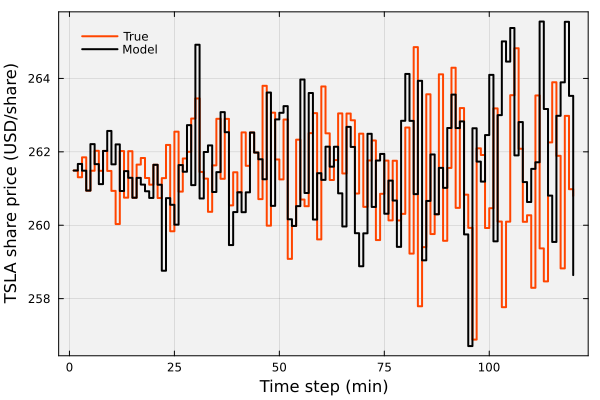

In [25]:
let
    plot(share_price_true, linetype=:steppost, label="True", lw=2, c=:orangered1, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)

     plot!(share_price_model, linetype=:steppost, label="Model", lw=2, c=:black, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)

    xlabel!("Time step (min)", fontsize=18)
    ylabel!("TSLA share price (USD/share)", fontsize=18)
end

In [26]:
price_corr_true_model = cor(share_price_true, share_price_model);
println("The correlation between the true and model price sequence: $(price_corr_true_model)")

The correlation between the true and model price sequence: -0.05535392602212004


* __Summary volatility__: The `true` and `model` volatility sequences appear similar, as expected, because they are drawn from the same underlying distribution. The correlation between the true and model sequences is weak ($|\rho|<0.3$), at least for the chosen `sample_synthetic_index_model` when this commentary was written.

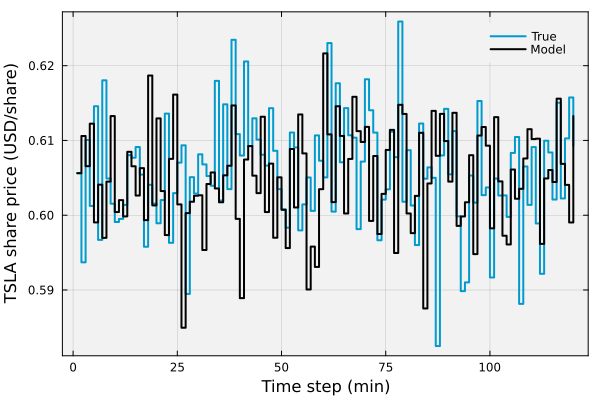

In [28]:
let
    plot(volatility_true, linetype=:steppost, label="True", lw=2, c=:deepskyblue3, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)

     plot!(volatility_model, linetype=:steppost, label="Model", lw=2, c=:black, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)

    xlabel!("Time step (min)", fontsize=18)
    ylabel!("TSLA share price (USD/share)", fontsize=18)
end

In [29]:
vol_corr_true_model = cor(volatility_true,volatility_model);
println("The correlation between the true and model volatility sequence: $(vol_corr_true_model)")

The correlation between the true and model volatility sequence: 0.17486516401975613


## Task 2: Hedge simulation with information mismatch
Now that we have the data series for the `true` and `model` price and volatility let's simulate the dynamics and performance of the equity hedge on the `TSLA` put option. First, we'll build a model of the put contract, then we'll simulate the hedge dynamics, and finally, we'll contract a table holding data, e.g., the liquidation value of the hedged position, over time for the `true` and `model` data streams. 

### TODO: Build a put contract model
To begin, let's build a [MyAmericanPutContractModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}). 
* The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}) takes two arguments: first, we pass in the type that we want to build, and second we pass data required to initialize the [MyAmericanPutContractModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) packaged in a [Julia NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple). We store the contract model in the `put_option_model::MyAmericanPutContractModel` variable.

In [32]:
put_option_model = build(MyAmericanPutContractModel, (
    K = example_put_contract["details"]["strike_price"], # random contract
    premium = example_put_contract["last_quote"]["midpoint"], # use last quote midpoint price from the random contract
    DTE = T,
    sense = 1,
    copy = 1,
    IV = example_put_contract["implied_volatility"], # use observed IV value
));

### TODO: Simulate a Dynamic Equity Hedge Assuming Mismatched Information 
We are ready to simulate the hedge on the `TSLA` put option using a single `for-loop` over the `number_of_trading_periods` minutes. To store the simulation data, we initialize the `hedge_simulation_mismatch::Dict{Int64, NamedTuple}` dictionary, where the keys hold the period index and the values are [Julia NamedTuple instances](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple). We also initialize the initial number of shares in the hedge `nₒ::Float64`, the initial option premium value `Pₒ::Float64`, and several other values required by the simulation. Then, for each iteration of the loop, we:
* Compute (or access) the data needed to compute the option premium in time period $i$ for true information and incorrect information used by the model. First, we reduce the duration of the contract by one trading period, i.e., one minute, and store this in the `Tᵢ::Float64` variable. Then we access the new `true` share price `Sᵢ::Float64,` and the `model` share price `Ŝᵢ::Float64`  and implied volatility `σᵢ::Float64` (or `σ̂ᵢ::Float64`) from the share_price and volatility arrays.
* Next, we compute the option premium in the interval $i$ using a [binomial tree methodology](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#Binomial-pricing-model) for both the `true` and `model` data and save these value in the `Pᵢ::Float64` and `P̂ᵢ::Float64` variables, respectively. This calculation first builds a [MyAdjacencyBasedCRREquityPriceTree instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAdjacencyBasedCRREquityPriceTree), fills in the tree using the [`populate(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.populate-Tuple{MyAdjacencyBasedCRREquityPriceTree}) and computes the new contract premium using the [`premium(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.premium).
* After calculating the updated value for the number of shares (`nᵢ::Float64` for the real scenario or `n̂ᵢ::Float64` for the modeled scenario) in the hedge, along with other relevant data for the trading period, we record this information in the `hedge_simulation_mismatch` dictionary. Additionally, we adjust the number of shares, premium, share price, and so forth for the next interval.

In [34]:
hedge_simulation_mismatch = Dict{Int64,NamedTuple}();
nₒ, Pₒ = 100*abs(example_put_contract["greeks"]["delta"]), put_option_model.premium;
Sₒ = example_put_contract["underlying_asset"]["price"]; # TSLA share price
σₒ = example_put_contract["implied_volatility"]; # IV for i = 9 put with 60-DTE
Tₒ = put_option_model.DTE;

# Initially assume true and model are the same -
n̂ₒ,P̂ₒ,Ŝₒ,σ̂ₒ = nₒ,Pₒ,Sₒ,σₒ;

# main simulation
for i ∈ 1:(number_of_trading_periods - 1)

    # get data for this trading period
    Tᵢ = Tₒ - (i)*Δt;
    Sᵢ = share_price_true[i+1]; # note: i = 1 is the *current* time point, i + 1 is the *next* value (end of the period)
    Ŝᵢ = share_price_model[i+1];    
    σᵢ = volatility_true[i+1];
    σ̂ᵢ = volatility_model[i+1];
    
    # compute the premium using CRR for true -
    Pᵢ = build(MyAdjacencyBasedCRREquityPriceTree, 
        (μ = risk_free_rate, T = Tᵢ, σ = σᵢ)) |> (x-> populate(x, Sₒ = Sᵢ, h = h)) |> mᵢ -> premium(put_option_model, mᵢ, sigdigits = 6);
    dPᵢ = (Pᵢ - Pₒ);

    # compute the premium using CRR for model -
    P̂ᵢ = build(MyAdjacencyBasedCRREquityPriceTree, 
        (μ = risk_free_rate, T = Tᵢ, σ = σ̂ᵢ)) |> (x-> populate(x, Sₒ = Ŝᵢ, h = h)) |> mᵢ -> premium(put_option_model, mᵢ, sigdigits = 6);
    dP̂ᵢ = (P̂ᵢ - P̂ₒ);
    
    # compute the delta hedge (number of shares we need to be long in the counter asset)
    nᵢ = nₒ*(Sₒ/Sᵢ) - 100*(dPᵢ)/Sᵢ; # new shares for true data
    n̂ᵢ = n̂ₒ*(Ŝₒ/Ŝᵢ) - 100*(dP̂ᵢ)/Ŝᵢ; # new shares for model data
    ϵᵢ = (nᵢ*Sᵢ - nₒ*Sₒ) + 100*(Pᵢ - Pₒ) # residual true
    ϵ̂ᵢ = (n̂ᵢ*Sᵢ - n̂ₒ*Sₒ) + 100*(Pᵢ - Pₒ) # residual model
   
    dnᵢ = (nᵢ - nₒ);
    dn̂ᵢ = (n̂ᵢ - n̂ₒ);
    Cᵢ = -sign(dnᵢ)*abs(dnᵢ)*Sᵢ;
    Ĉᵢ = -sign(dn̂ᵢ)*abs(dn̂ᵢ)*Ŝᵢ;

    LVT = (100*Pᵢ + nᵢ*Sᵢ)
    LVM = (100*Pᵢ + n̂ᵢ*Sᵢ)
    Z = ((LVT - LVM)/LVT)*100;
    
    # data capture -
    hedge_simulation_mismatch[i] = (premium_delta_true = dPᵢ, premium_delta_model = dP̂ᵢ, 
        share_delta_true = dnᵢ, share_delta_model = dn̂ᵢ, share_price_true_next = Sᵢ, share_price_model_next = Ŝᵢ, 
        hedge_cost_true = Cᵢ, hedge_cost_model = Ĉᵢ, residual_true = ϵᵢ, residual_model = ϵ̂ᵢ, LVM = LVM, LVT = LVT, Z = Z,
        shares_true = nᵢ, shares_model = n̂ᵢ)

    # variable update -
    nₒ = nᵢ; # update the shares at the start of the next interval for true data
    n̂ₒ = n̂ᵢ; # update the shares at the start of the next interval for model data
    Pₒ = Pᵢ; # update the premium at the start of the next interval for true data
    P̂ₒ = P̂ᵢ; # update the premium at the start of the next interval for model data
    Sₒ = Sᵢ; # update the share price at the start of the next interval for true data
    Ŝₒ = Ŝᵢ; # update the share price at the start of the next interval for model data
    σₒ = σᵢ; # update the implied volatility for the true data
    σ̂ₒ = σ̂ᵢ; # update the implied volatility for the model data
end

### Visualize the true and model hedge trajectory
`Unihide` the code block below to see how we plotted the $n_{t+dt}$ trajectory for the selected `TSLA` put option.

#### Summary
* We initially start the simulation with $100\times|\Delta_{p}|$ shares of `TSLA,` i.e., we use the equivalent share meaning of delta to perfectly balance the long and short positions in `TSLA` represented by the long put option (short shares) and the long equity position.
* As time moves in 1-minute increments, we buy or sell `TSLA` shares to perfectly compensate for changes in the options premium. The size of the counter-share position varies between approximately 42 shares and 44 shares, or about `5.0%` over the 120 simulation period for the chosen options contract. However, these values could change significantly if a different put option contract is chosen.
* As expected, the `true` and `model` data streams give quantitively different share counts, but they appear qualitatively similar.

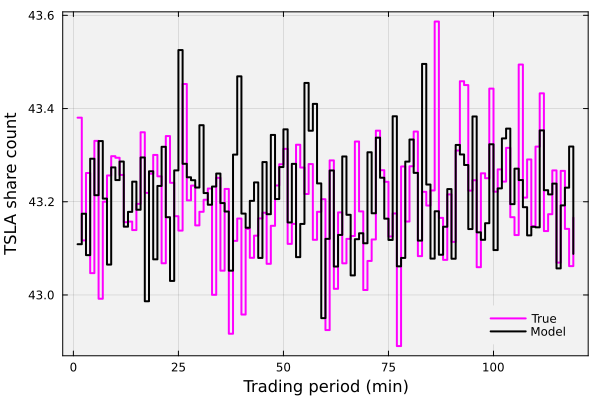

In [36]:
let
    local_data_array = Array{Float64,2}(undef, number_of_trading_periods - 1, 3);
    for i ∈ 1:(number_of_trading_periods - 1)
        local_data_array[i, 1] = i;
        local_data_array[i, 2] = hedge_simulation_mismatch[i].shares_true
        local_data_array[i, 3] = hedge_simulation_mismatch[i].shares_model
    end

    plot(local_data_array[:,1], local_data_array[:,2], linetype=:steppost, label="True", lw=2, c=:magenta1, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(local_data_array[:,1], local_data_array[:,3], linetype=:steppost, label="Model", lw=2, c=:black, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Trading period (min)", fontsize=18)
    ylabel!("TSLA share count", fontsize=18)
end

### TODO: Build profit, loss, and cost table for the incorrectly hedged TSLA position
`Unhide` the code block below to see how we constructed a table holding the hedging data for the mismatched information case using [a DataFrame](https://github.com/JuliaData/DataFrames.jl) in combination with [the `pretty_tables(...)` function exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl). We show hedging data for the first 20 minutes of the simulation.

#### Summary
* In each period, the share difference between the `true` and `model` data leads to different trade decisions due to incorrect information. However, the cumulative rebalancing costs are minimal when comparing the liquidation values of the actual and model positions. The relative percentage error between the `LVT` and `LVM` columns is less than 1% over the 2-hour time window shown.
* The liquidation values of two approaches, one with accurate data and the other with mismatched data, are surprisingly similar even when using incorrect information to rebalance. One might expect that as the degree of misinformation increases (i.e., the gap between what the model predicts the price and volatility to be and their actual values), the difference between the liquidation values would also increase. However, we leave these future studies up to the students of this course. Please test it out and let us know!

In [38]:
let
    
    perfect_hedge_simulation_example = my_simulation_dict["perfect_hedge_simulation_example"]; # load previous simulation values
    n̄, P̄, S̄ = 100*abs(example_put_contract["greeks"]["delta"]), put_option_model.premium, example_put_contract["underlying_asset"]["price"];
    C̄ = (n̄*S̄ + 100*P̄); # cost associated with the position
    
    tmp = DataFrame();
    tmp_cost_sum_true = Array{Float64,1}();
    tmp_cost_sum_model = Array{Float64,1}();
    
    for i ∈ 1:(number_of_trading_periods - 1)

        data_tuple = hedge_simulation_mismatch[i];
        LVT = data_tuple.LVT;
        LVM = data_tuple.LVM;
        PE = data_tuple.Z;
        C = data_tuple.hedge_cost_true;
        Ĉ = data_tuple.hedge_cost_model;
        dn = data_tuple.share_delta_true;
        dn̂ = data_tuple.share_delta_model;

        push!(tmp_cost_sum_true,C);
        push!(tmp_cost_sum_model,Ĉ);
        
        # package -
        row_df = (
            i = (i),
            dn = dn,
            dn̂ = dn̂,
            Σ = sum(tmp_cost_sum_true),
            Σ̂ = sum(tmp_cost_sum_model),
            LVT = LVT,
            LVM = LVM,
            PE = PE,
        );
        push!(tmp, row_df)
    end
    pretty_table(tmp[1:20,:])
end

┌───────┬─────────────┬────────────┬───────────┬──────────┬─────────┬─────────┬─────────────┐
│     i │          dn │         dn̂ │         Σ │        Σ̂ │     LVT │     LVM │          PE │
│ Int64 │     Float64 │    Float64 │   Float64 │  Float64 │ Float64 │ Float64 │     Float64 │
├───────┼─────────────┼────────────┼───────────┼──────────┼─────────┼─────────┼─────────────┤
│     1 │   0.0814122 │  -0.190132 │  -21.2736 │  49.7519 │ 13692.2 │ 13621.3 │    0.518225 │
│     2 │   -0.263345 │  0.0654883 │   47.6832 │  32.6275 │ 13692.2 │ 13707.2 │   -0.109559 │
│     3 │    0.144623 │  -0.088834 │   9.94473 │  55.8081 │ 13692.2 │ 13646.3 │    0.335737 │
│     4 │   -0.214849 │   0.206843 │   66.1245 │  1.57166 │ 13692.2 │ 13756.4 │   -0.468884 │
│     5 │     0.28378 │  -0.078273 │  -8.23369 │   22.053 │ 13692.2 │ 13661.7 │    0.223001 │
│     6 │   -0.338711 │   0.116142 │   80.3332 │ -8.27397 │ 13692.2 │ 13780.7 │     -0.6461 │
│     7 │    0.208294 │  -0.123541 │    25.755 │   24.097 

`Unhide` the code block below to see how we plotted the liquidation value for the `true` hedged position (the `LVT` column) and the `TSLA` position hedged with incorrect information (the `LVM` column).

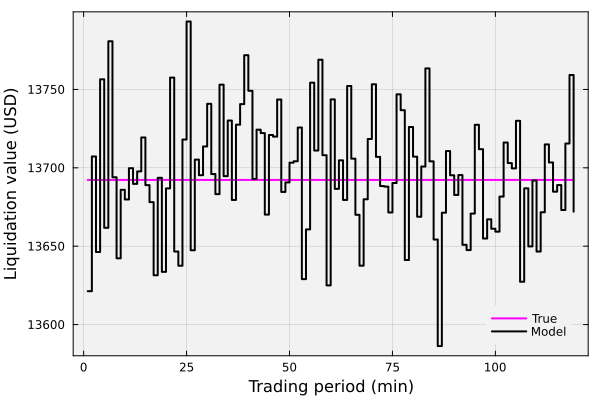

In [61]:
let
    local_data_array = Array{Float64,2}(undef, number_of_trading_periods - 1, 3);
    for i ∈ 1:(number_of_trading_periods - 1)
        local_data_array[i, 1] = i;
        local_data_array[i, 2] = hedge_simulation_mismatch[i].LVT
        local_data_array[i, 3] = hedge_simulation_mismatch[i].LVM
    end

    plot(local_data_array[:,1], local_data_array[:,2], linetype=:steppost, label="True", lw=2, c=:magenta1, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(local_data_array[:,1], local_data_array[:,3], linetype=:steppost, label="Model", lw=2, c=:black, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Trading period (min)", fontsize=18)
    ylabel!("Liquidation value (USD)", fontsize=18)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.